In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import math

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
# Define the size of training data and validation data generated
num_train_1 = 2000
num_train_2 = 2000
num_val_1 = 500
num_val_2 = 500

# Training data in class 1 has mean (0, 1.5) and variance 1
gaussian_1 = np.random.randn(num_train_1, 2) + np.concatenate((np.zeros((num_train_1, 1)), 1.5 * np.ones((num_train_1, 1))), axis=1)
label_1 = np.zeros(num_train_1)

# Training data in class 2 has mean (0, -1.5) and variance 1
gaussian_2 = np.random.randn(num_train_2, 2) + np.concatenate((np.zeros((num_train_2, 1)), -1.5 *np.ones((num_train_2, 1))), axis=1)
label_2 = np.ones(num_train_2)

x_train = np.concatenate((gaussian_1, gaussian_2), axis=0)
t_train = np.concatenate((label_1, label_2), axis=0)

# Validation data in class 1 has mean (0, 1.5) and variance 1
gaussian_val_1 = np.random.randn(num_val_1, 2) + np.concatenate((np.zeros((num_val_1, 1)), 1.5 * np.ones((num_val_1, 1))), axis=1)
label_val_1 = np.zeros(num_val_1)

# Validation data in class 2 has mean (0, -1.5) and variance 1
gaussian_val_2 = np.random.randn(num_val_2, 2) + np.concatenate((np.zeros((num_val_2, 1)), -1.5 * np.ones((num_val_2, 1))), axis=1)
label_val_2 = np.ones(num_val_2)

x_val = np.concatenate((gaussian_val_1, gaussian_val_2), axis=0)
t_val = np.concatenate((label_val_1, label_val_2), axis=0)

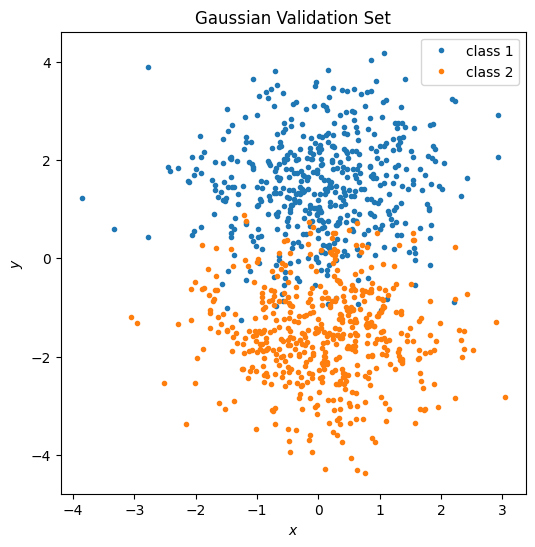

In [17]:
# Plot the validation set
plt.figure(figsize=(6, 6))
plt.plot(gaussian_val_1[:, 0], gaussian_val_1[:, 1], '.', label='class 1')
plt.plot(gaussian_val_2[:, 0], gaussian_val_2[:, 1], '.', label='class 2')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Gaussian Validation Set')
plt.legend(loc='best')
plt.savefig('drive/MyDrive/deep-learning/final_project/gaussian_validation.png', dpi=300)
plt.show()

In [5]:
class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        self.x_train = x_train
        self.t_train = t_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.t_train[idx], dtype=torch.long)

train_data = train_dataset(x_train, t_train)
val_data = train_dataset(x_val, t_val)

In [6]:
# Prepare for batch training
batch_size = 20

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_val = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

In [7]:
def relu(x):
    # Use torch.where() to write ReLU
    x = torch.where(x > 0, x, torch.zeros_like(x))
    return x

def softmax(x):
    # Substract each element in x by the maximum value on dimension 1
    x -= torch.cat([x.max(axis=1, keepdim=True).values] * x.size()[1], dim=1)
    x_exp = torch.exp(x)
    return x_exp/torch.cat([x_exp.sum(dim=1, keepdim=True)] * x.size()[1], dim=1)

class Dense(nn.Module):
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        super().__init__()
        # He Initialization
        # in_dim: input dimension; out_dim: output dimension
        # He initialization
        self.W = nn.Parameter(torch.tensor(np.random.uniform(
                        low=-np.sqrt(6/in_dim),
                        high=np.sqrt(6/in_dim),
                        size=(in_dim, out_dim)
                    ).astype('float32')))
        self.b = nn.Parameter(torch.tensor(np.zeros([out_dim]).astype('float32')))
        self.function = function

    def forward(self, x):
        return self.function(torch.matmul(x, self.W) + self.b)


class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim_1, hid_dim_2, out_dim):
        # equivalent to super().__init__() that enables inheritance
        super(MLP, self).__init__()
        self.linear1 = Dense(in_dim, hid_dim_1, function=relu)
        self.linear2 = Dense(hid_dim_1, hid_dim_2, function=relu)
        self.linear3 = Dense(hid_dim_2, out_dim, function=softmax)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [8]:
# Initialize hyperparameters
in_dim = 2
hid_dim_1 = 40
hid_dim_2 = 40
out_dim = 2
lr = 0.01
n_epochs = 1
realizations = 1

In [9]:
# Define the test set at each step to be a grid
x_coords = torch.arange(-2, 2, 0.02)
y_coords = torch.arange(-2, 2, 0.02)
x_test = torch.cartesian_prod(x_coords, y_coords)

In [10]:
def get_decision_boundary(x_coords, y_coords, x_pred):
    '''Obtain the decision boundary from prediction data.'''
    # Initialize the decision boundary array
    decision_boundary = np.stack((x_coords.numpy(), np.zeros(len(x_coords))))

    for i in range(len(x_coords)):
        # Retrieve all decisions along a vertical give x coordinate
        vert_decisions = x_pred[i*len(y_coords):(i+1)*len(y_coords)]

        # Start from the middle of the vertical line to
        # decide the position of the decision boundary
        start_pos = int(len(y_coords)/2)
        for j in range(1, int(len(y_coords)/2)):
            if vert_decisions[start_pos+j, 2] != vert_decisions[start_pos+j-1, 2]:
                decision_boundary[1, i] = vert_decisions[start_pos+j, 1]
                break
            elif vert_decisions[start_pos-j, 2] != vert_decisions[start_pos-j+1, 2]:
                decision_boundary[1, i] = vert_decisions[start_pos-j, 1]
                break

    return decision_boundary

In [11]:
# Train and save data for each network structure
for i in range(realizations):
    # Initialize the network for each realization
    mlp = MLP(in_dim, hid_dim_1, hid_dim_2, out_dim).to(device)
    optimizer = optim.SGD(mlp.parameters(), lr=lr)

    for epoch in range(n_epochs):
        losses_train = []
        losses_valid = []
        train_num = 0
        train_true_num = 0
        valid_num = 0
        valid_true_num = 0
        height_std = []

        mlp.train() # Train mode for training (allow computation of gradients)
        for x, t in dataloader_train:
            # Convert true label to one-hot vector
            true = t.tolist()
            t_hot = torch.eye(2)[t]

            # Move tensors to GPU
            x = x.to(device)
            t_hot = t_hot.to(device)

            # Forward propagation
            # Equivalent to y = mlp.forward(x) since forward() is a built-in method of nn.Module class
            y = mlp(x)

            # Compute loss function
            loss = -(t_hot * torch.log(y)).sum(axis=1).mean()

            # Backprop
            optimizer.zero_grad()
            loss.backward()

            # Update parameters
            optimizer.step()

            # Convert model output to predicted values
            pred = y.argmax(dim=1)

            losses_train.append(loss.tolist())

            # Compute accuracy score
            acc = torch.where(t - pred.to("cpu") == 0, torch.ones_like(t), torch.zeros_like(t))
            train_num += acc.size()[0]
            train_true_num += acc.sum().item()

        mlp.eval() # Eval mode for training (disable computation of gradients)
        for x, t in dataloader_val:
            # Convert true label to one-hot vector
            true = t.tolist()
            t_hot = torch.eye(2)[t]

            # Move tensors to GPU
            x = x.to(device)
            t_hot = t_hot.to(device)

            # Forward propagation
            # Equivalent to y = mlp.forward(x) since forward() is a built-in method of nn.Module class
            y = mlp(x)

            # Compute loss function
            loss = -(t_hot * torch.log(y)).sum(axis=1).mean()

            pred = y.argmax(1)

            # Convert model output to predicted values
            losses_valid.append(loss.tolist())

            # Compute accuracy score
            acc = torch.where(t - pred.to("cpu") == 0, torch.ones_like(t), torch.zeros_like(t))
            valid_num += acc.size()[0]
            valid_true_num += acc.sum().item()

        # Plot the result for validation
        # plt.figure(figsize=(5, 5))
        # plt.plot(x_1_arr[:, 0], x_1_arr[:, 1], '.', label='class 1')
        # plt.plot(x_2_arr[:, 0], x_2_arr[:, 1], '.', label='class 2')
        # plt.xlabel(r'$x$')
        # plt.ylabel(r'$y$')
        # plt.legend(loc='best')
        # plt.show()


        print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
            epoch,
            np.mean(losses_train),
            train_true_num/train_num,
            np.mean(losses_valid),
            valid_true_num/valid_num
        ))

EPOCH: 0, Train [Loss: 0.178, Accuracy: 0.928], Valid [Loss: 0.168, Accuracy: 0.925]


In [53]:
# Collect test data to draw the decision boundary
y = mlp(x_test.to(device))
pred_test = y.argmax(dim=1)

x_pred = torch.cat((x_test.to(device), pred_test.reshape(-1, 1)), dim=1)

x_1_tensor = x_pred[x_pred[:, 2] == 0.0][:, :2]
x_2_tensor = x_pred[x_pred[:, 2] == 1.0][:, :2]

decision_boundary = get_decision_boundary(x_coords, y_coords, x_pred)

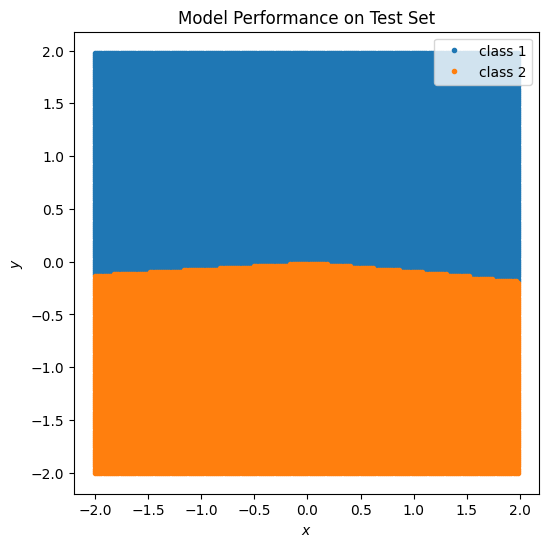

In [54]:
plt.figure(figsize=(6, 6))
plt.plot(x_1_tensor[:, 0], x_1_tensor[:, 1], '.', label='class 1')
plt.plot(x_2_tensor[:, 0], x_2_tensor[:, 1], '.', label='class 2')
plt.plot()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Model Performance on Test Set')
plt.legend(loc='best')
plt.show()

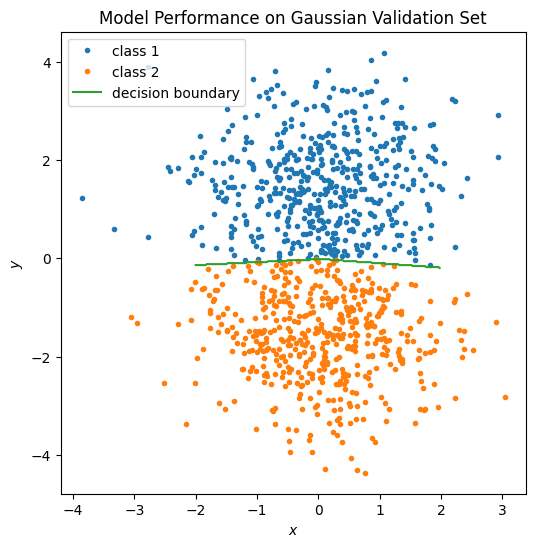

In [55]:
# Performance of the trained model on the validation set
y = mlp(torch.tensor(x_val, dtype=torch.float32).to(device))
pred_test = y.argmax(dim=1)

x_pred = torch.cat((torch.tensor(x_val).to(device), pred_test.reshape(-1, 1)), dim=1)

x_1_tensor = x_pred[x_pred[:, 2] == 0.0][:, :2]
x_2_tensor = x_pred[x_pred[:, 2] == 1.0][:, :2]

plt.figure(figsize=(6, 6))
plt.plot(x_1_tensor[:, 0], x_1_tensor[:, 1], '.', label='class 1')
plt.plot(x_2_tensor[:, 0], x_2_tensor[:, 1], '.', label='class 2')
plt.plot(decision_boundary[0, :], decision_boundary[1, :], label='decision boundary')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Model Performance on Gaussian Validation Set')
plt.legend(loc='best')
plt.savefig('drive/MyDrive/deep-learning/final_project/model_gaussian_validation.png', dpi=300)
plt.show()